# **Example PSI Model Synthesis Notebook**

Tom Schad 

----

- This notebook does an example synthesis of the global corona using a Predictive Sciences MHD model. 
- Most of the details for synthesis of any line at any time can be gleaned from this example; however, it is not currently build as its own class.  A module 'psi.py' is available in the examples directory to interact with the PSI models.  At some point, this may evolve into its own package. 

**A note on speed**
- This example demonstrates the forward synthesis of the Fe XIII 1074.6 nm emission line, and it uses an atomic model consisting of 50 levels. Schad & Dima (2020) discuss the relative accuracy of using models of various size, as well as the fact that computational cost increases dramatically with the number of levels included.  
- Some authors have built reduced size atomic models that attempt to emulate the behavior of a larger model atom.  While this can increase the speed of the computations, one should be careful that such models are accurate enough for your particular application.  The pyCELP ion class has been build in such a way that parallel processing is easily accomplished with the standard python tools.  
- Alternatively one could build databases in the manner of Schad & Dima (2020) to accelerate calculations over multiple datasets. 
----

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=6
os.environ['NUMEXPR_MAX_THREADS'] = '1'

import pycelp 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["XUVTOP"] = '/usr/local/ssw/packages/chianti/dbase/'
import psi
import sunpy.coordinates.sun as sun
import sunpy.sun.constants as constants
plt.rcParams["image.origin"]='lower'   ## have to worry about flips? 
plt.rcParams["image.interpolation"]='nearest'
from scipy.interpolate import RegularGridInterpolator as rgi
from scipy.interpolate import interp1d
import multiprocessing
import tqdm
from matplotlib.colors import LogNorm
import pycelp.allenSolRad as allen

from scipy.io import readsav
import sunpy
import sunpy.map
from sunpy.coordinates.ephemeris import get_horizons_coord
from sunpy.coordinates import frames
from sunpy.coordinates import sun
from astropy.coordinates import SkyCoord
from astropy.time  import Time,TimeDelta
from astropy.coordinates import EarthLocation, AltAz
from astropy import units as u
from matplotlib.colors import PowerNorm,SymLogNorm
from scipy.interpolate import griddata
from matplotlib.image import NonUniformImage

def euler_ry(alpha):
    '''Euler rotation matrix about y axis '''
    ry = np.array([[ np.cos(alpha), 0., np.sin(alpha)],
                   [            0., 1., 0.],
                   [-np.sin(alpha), 0., np.cos(alpha)]])
    return ry

def euler_rz(alpha):
    '''Euler rotation matrix about z axis '''
    rz = np.array([[ np.cos(alpha), -np.sin(alpha), 0.],
                   [ np.sin(alpha),  np.cos(alpha), 0.],
                   [            0.,             0., 1.]])
    return rz

## **Create an instance of the psi.Model class to load and interact with PSI coronal model data**

- Models used here were downloaded using this website from [Predictive Sciences](https://www.predsci.com/hmi/data_access.php)
- We picked the date of the US total solar eclipse (21 Aug 2017) using the med-cor-thermo2 model for this demonstration. 
- I had selected 12 UTC for the download time.  I'm not sure at this time where timestep information in the PSI models made be located.

In [2]:
## https://www.predsci.com/data/runs/cr2194-medium/hmi_mast_mas_std_0201/
## carrington rotation 2194
modelName = 'hmi__med-cor-thermo2-std01__med-hel-poly-std01'
corona = psi.Model('/data/tschad/psiModels/21Aug2017_thermo2_12UTC/corona/')

In [3]:
## return the instance name for some basic information on the class
corona

psi Model class
    ---------------------
    Data Directory Names: /data/tschad/psiModels/21Aug2017_thermo2_12UTC/corona/
    Number of longitude samples: 181
    Number of latitude samples: 100
    Number of radial samples: 150
    Data shape: (181, 100, 150)
    
    Variables: 
    lons -- Longitudes [rad]
    lats -- Latitudes [rad]
    rs   -- Radial samples [solar radii units]
    temp -- temperature [K]
    ne -- electron density [cm^-3]
    bx,by,bz  -- Cartesian components of magnetic field [G]
    vx,vy,vz  -- Cartesian components of velocity field [km/s]
    bmag      -- total magnetic field intensity [B]
    thetaBlocal -- location inclination of magnetic field in solar frame [rad]
    

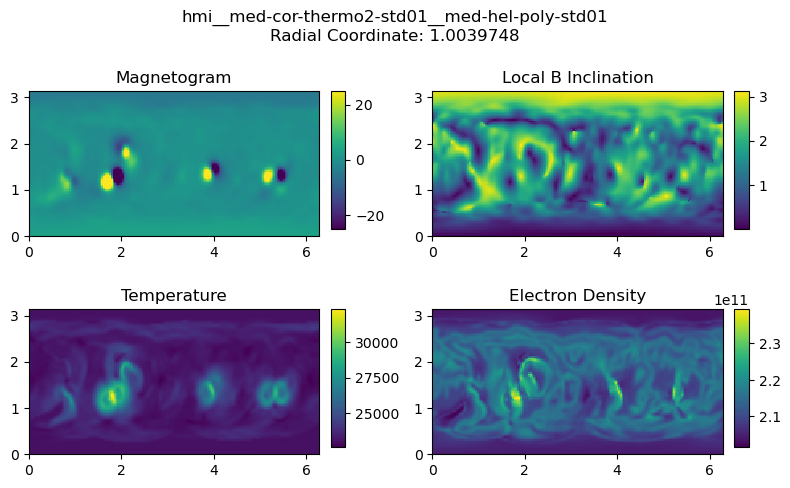

In [4]:
kk = 5

fig,ax = plt.subplots(2,2,figsize = (8,5))
ax = ax.flatten()
im0 = ax[0].imshow(corona.bmag[:,:,kk].T*np.cos(corona.thetaBlocal[:,:,kk]).T,extent = (corona.lons.min(),corona.lons.max(),corona.lats.min(),corona.lats.max()))
ax[1].imshow(corona.thetaBlocal[:,:,kk].T,extent = (corona.lons.min(),corona.lons.max(),corona.lats.min(),corona.lats.max()))
ax[2].imshow(corona.temp[:,:,kk].T,extent = (corona.lons.min(),corona.lons.max(),corona.lats.min(),corona.lats.max()))
ax[3].imshow(corona.ne[:,:,kk].T,extent = (corona.lons.min(),corona.lons.max(),corona.lats.min(),corona.lats.max()))
labels = 'Magnetogram','Local B Inclination','Temperature','Electron Density'
for n in range(4): ax[n].set_title(labels[n])

im0.set_clim(-25,25)

cbars = []
for axi in ax:
 cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
 cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
 cbars.append(cbar1)

fig.suptitle(modelName + '\nRadial Coordinate: ' + str(corona.rs[kk]))

fig.tight_layout()

In [5]:
## Set up example Coordinates for an instrument (such as DKIST/CryoNIRSP) 

haleakala = EarthLocation(lat=20.706760*u.deg,
            lon=-(156.256262)*u.deg,
            height=3067.*u.m)

observerDKIST =SkyCoord(haleakala.get_gcrs(Time('2017-08-21T12:00:00.000')))
ff = frames.HeliographicCarrington(observer=observerDKIST)
rr = sunpy.coordinates.utils.get_limb_coordinates(observerDKIST)


In [6]:
from tqdm.auto import trange
latlon = np.zeros((2,len(rr)))
for n in trange(len(rr)):
    coord = rr[n]
    lc = coord.transform_to(ff)
    latlon[0,n] = lc.lat.rad
    latlon[1,n] = lc.lon.rad

sortlon = np.argsort(latlon[1,:])
latlon[0,:]= latlon[0,:][sortlon]
latlon[1,:]= latlon[1,:][sortlon]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
## CryoNIRSP - > DKIST boresight example
xbore,ybore = -1000,100
coord = SkyCoord(xbore*u.arcsec, ybore*u.arcsec, frame=frames.Helioprojective, obstime="2017-08-21T12:00:00.000", observer="earth")
with frames.Helioprojective.assume_spherical_screen(coord.observer):
    chc1 = coord.transform_to(frames.HeliographicCarrington)

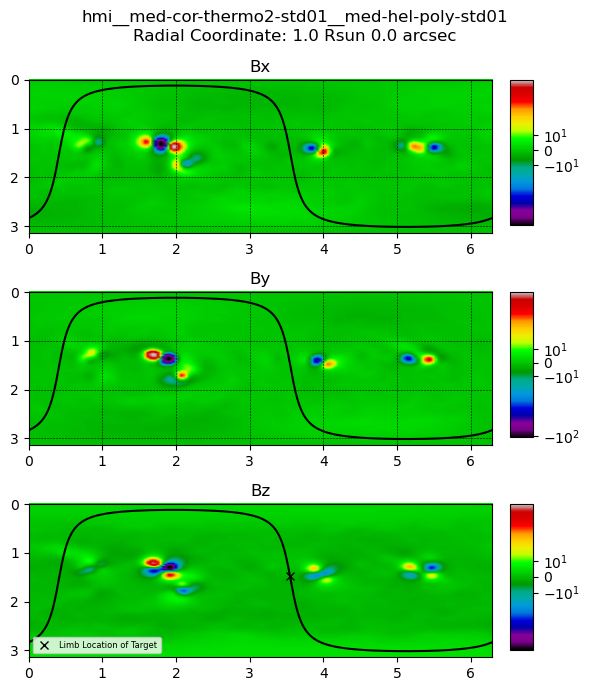

In [8]:
fig,ax = plt.subplots(3,1,figsize = (6,7))
ax = ax.flatten()
kk = 0

axi = ax[0]
im = NonUniformImage(axi, interpolation = 'bilinear',extent=(0,2.*np.pi,0,np.pi), cmap = 'nipy_spectral',norm = SymLogNorm(40))
im.set_data(corona.lons,corona.lats,corona.bx[:,:,kk].T)
axi.add_image(im)
axi.set_xlim(0,2.*np.pi)
axi.set_ylim(np.pi,0.)

axi = ax[1]
im = NonUniformImage(axi, interpolation = 'bilinear',extent=(0,2.*np.pi,0,np.pi),cmap =  'nipy_spectral',norm = SymLogNorm(40))
im.set_data(corona.lons,corona.lats,corona.by[:,:,kk].T)
axi.add_image(im)
axi.set_xlim(0,2.*np.pi)
axi.set_ylim(np.pi,0.)

axi = ax[2]
im = NonUniformImage(axi, interpolation = 'bilinear',extent=(0,2.*np.pi,0,np.pi),cmap =  'nipy_spectral',norm = SymLogNorm(40))
im.set_data(corona.lons,corona.lats,corona.bz[:,:,kk].T)
axi.add_image(im)
axi.set_xlim(0,2.*np.pi)
axi.set_ylim(np.pi,0.)

for axi in ax: 
    axi.plot(latlon[1,:],-latlon[0,:]+np.pi/2.,'-',color = 'black')
    cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
    cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
    axi.set_ylim(np.pi,0)

## cirle 
axi.plot(chc1.lon.rad,-chc1.lat.rad+np.pi/2.,'x',color = 'black',label = 'Limb Location of Target')
axi.legend(ncol = 1,loc = 'lower left',fontsize = 6)

ax[0].grid(ls = 'dashed',color = 'black',lw = 0.4)
ax[1].grid(ls = 'dashed',color = 'black',lw = 0.4)

fig.suptitle(modelName + '\nRadial Coordinate: ' + str(corona.rs[kk]) + ' Rsun ' + str(np.round((corona.rs[kk]-1)*960.,2)) + ' arcsec')

ax[0].set_title('Bx')
ax[1].set_title('By')
ax[2].set_title('Bz')

clim = np.max(np.abs(im.get_clim()))
im.set_clim(-clim,clim)

fig.tight_layout()

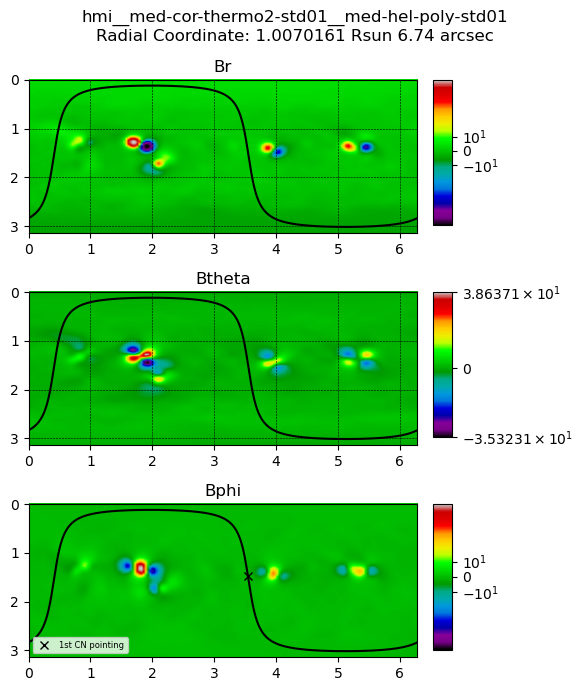

In [9]:
fig,ax = plt.subplots(3,1,figsize = (6,7))
ax = ax.flatten()
kk = 10

axi = ax[0]
im = NonUniformImage(axi, interpolation = 'bilinear',extent=(0,2.*np.pi,0,np.pi), cmap = 'nipy_spectral',norm = SymLogNorm(40))
im.set_data(corona.lons,corona.lats,corona.br[:,:,kk].T)
axi.add_image(im)
axi.set_xlim(0,2.*np.pi)
axi.set_ylim(np.pi,0.)

axi = ax[1]
im = NonUniformImage(axi, interpolation = 'bilinear',extent=(0,2.*np.pi,0,np.pi),cmap =  'nipy_spectral',norm = SymLogNorm(40))
im.set_data(corona.lons,corona.lats,corona.bt[:,:,kk].T)
axi.add_image(im)
axi.set_xlim(0,2.*np.pi)
axi.set_ylim(np.pi,0.)

axi = ax[2]
im = NonUniformImage(axi, interpolation = 'bilinear',extent=(0,2.*np.pi,0,np.pi),cmap =  'nipy_spectral',norm = SymLogNorm(40))
im.set_data(corona.lons,corona.lats,corona.bp[:,:,kk].T)
axi.add_image(im)
axi.set_xlim(0,2.*np.pi)
axi.set_ylim(np.pi,0.)

for axi in ax: 
    axi.plot(latlon[1,:],-latlon[0,:]+np.pi/2.,'-',color = 'black')
    cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
    cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
    axi.set_ylim(np.pi,0)

## cirle 
axi.plot(chc1.lon.rad,-chc1.lat.rad+np.pi/2.,'x',color = 'black',label = '1st CN pointing')
#axi.plot(chc2.lon.rad,-chc2.lat.rad+np.pi/2.,'*',color = 'black',label = '2nd CN pointing')
axi.legend(ncol = 1,loc = 'lower left',fontsize = 6)

ax[0].grid(ls = 'dashed',color = 'black',lw = 0.4)
ax[1].grid(ls = 'dashed',color = 'black',lw = 0.4)

fig.suptitle(modelName + '\nRadial Coordinate: ' + str(corona.rs[kk]) + ' Rsun ' + str(np.round((corona.rs[kk]-1)*960.,2)) + ' arcsec')


ax[0].set_title('Br')
ax[1].set_title('Btheta')
ax[2].set_title('Bphi')

clim = np.max(np.abs(im.get_clim()))
im.set_clim(-clim,clim)

fig.tight_layout()

This is the GONG 2194_000 synoptic map 

<img src="https://gong.nso.edu/data/magmap/QR/mqj/201708/mrmqj170830/mrmqj170830t0205c2194_000.jpg" />

## **Initialize the pyCELP model of the line or lines to be synthesized**

- Here we start with Fe XIII 1074 nm and keep the model fairly "small" at 50 levels.  The errors incurred by using reduced numbers of atomic levels is addressed in [Schad & Dima (2020)](https://rdcu.be/b5J2X) 


In [10]:
fe13 = pycelp.Ion('fe_13',nlevels = 50)
fe13_ln1 = fe13.get_emissionLine(10747.)
fe13_ln2 = fe13.get_emissionLine(10798.)

 reading:  /usr/local/ssw/packages/chianti/dbase/fe/fe_13/fe_13.elvlc
 reading:  /usr/local/ssw/packages/chianti/dbase/fe/fe_13/fe_13.wgfa
 reading:  /usr/local/ssw/packages/chianti/dbase/fe/fe_13/fe_13.scups
 reading:  /usr/local/ssw/packages/chianti/dbase/fe/fe_13/fe_13.psplups
 using default abundances: /usr/local/ssw/packages/chianti/dbase/abundance/sun_photospheric_2009_asplund.abund
 reading:  /usr/local/ssw/packages/chianti/dbase/abundance/sun_photospheric_2009_asplund.abund
 testing default file: /usr/local/ssw/packages/chianti/dbase/ioneq/chianti.ioneq
 reading:  /usr/local/ssw/packages/chianti/dbase/ioneq/chianti.ioneq
 setting up electron collision rate factors
 setting up proton  collision rate factors
 setting up non-dipole radiative rate factors
 getting non-dipole rate factors
 setting up dipole radiative rate factors


In [11]:
fe13

pyCELP Ion class
    ---------------------
    Ion Name: fe_13
    Number of energy levels included: 50
    Number of SEE equations: 142
    Number of Radiative Transitions: 366
    Ionization Equilbrium Filename: /usr/local/ssw/packages/chianti/dbase/ioneq/chianti.ioneq

In [12]:
edens = 1e9
etemp = 1e7
ht = 0.1
thetab = 10.
%timeit fe13.calc_rho_sym(edens,etemp,ht, thetab)

633 µs ± 409 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## **Calculate the statistical equilibrium for every cell**

- Here the statistical equilibrium is calculated for the Ion for each cell in the PSI model and the results of the upper level populations, alignments, and total ion population are stored in arrays. 
- The advantage of doing it this way is that that statistical equilibrium does not change with viewing angle, and so if you want to synthesis the polarized intensities at a different viewing angle, you do not have to recalculate the statistical equilibrium. 

In [13]:
nlons,nlats,nr = corona.bx.shape

In [14]:
def work(argin): 
    
    ii,jj,kk = argin 
    
    edens = corona.ne[ii,jj,kk]
    etemp = corona.temp[ii,jj,kk]
    ht = (corona.rs[kk]-1).clip(1.e-8)
    thetab = np.rad2deg(corona.thetaBlocal[ii,jj,kk])
    
    fe13.calc_rho_sym(edens,etemp,ht, thetab)
    
    ln1 = fe13.get_emissionLine(10747.)
    ln2 = fe13.get_emissionLine(10798.)
    
    return (ii,jj,kk,ln1.C_coeff,ln1.upper_level_alignment, 
                ln2.C_coeff,ln2.upper_level_alignment)

## setup save file for repeat runs of this notebook and to not repeat the 
## statistical equilbrium calculation 

savefn = '/home/tschad/fe13_1074_1079_pops.npz'

if not os.path.isfile(savefn):

    ncpus = multiprocessing.cpu_count()
    arg_array = []
    for ii in range(0,nlons,1): 
        for jj in range(0,nlats,1): 
            for kk in range(0,nr,1): 
                arg_array.append([ii,jj,kk])

    ccoef_10747 = np.zeros_like(corona.bx)
    align_10747 = np.zeros_like(corona.bx)
    ccoef_10798 = np.zeros_like(corona.bx)
    align_10798 = np.zeros_like(corona.bx)

    p     = multiprocessing.Pool(processes=ncpus) 
    rs    = p.imap(work,arg_array)
    p.close()

    for res in tqdm.tqdm(rs,total = len(arg_array)): 
        ii,jj,kk,r1,a1,r2,a2 = res 
        ccoef_10747[ii,jj,kk] = r1
        align_10747[ii,jj,kk] = a1
        ccoef_10798[ii,jj,kk] = r2
        align_10798[ii,jj,kk] = a2

    np.savez(savefn,ccoef_10747=ccoef_10747,align_10747=align_10747,ccoef_10798=ccoef_10798,align_10798=align_10798)
    
else: 
    
    ## if variables not defined load 
    if "ccoef_10747" not in globals():
        print('loading: ',savefn)
        npzd = np.load(savefn)
        ccoef_10747 = npzd['ccoef_10747']
        align_10747 = npzd['align_10747']
        ccoef_10798 = npzd['ccoef_10798']
        align_10798 = npzd['align_10798']

loading:  /home/tschad/fe13_1074_1079_pops.npz


## **Setup forward synthesis geometry**

- This is set up to synthesize a FOV from an arbitrary observer's position, def

### Observer's Position

In [15]:
crn        = sun.carrington_rotation_number('2017-08-21T12:00:00.000')
crt        = sun.carrington_rotation_time(crn)
obsLon     = sun.L0(crt).rad
obsLat     = sun.B0(crt).rad
Obs_Sun_AU = sun.earth_distance(crt).value
rsunarc    = sun.angular_radius(crt).value  ## radius of sun in arcseconds .. later replace with sun ephemeris

print('Carrington Rotation Number:     ',crn)
print('Carrington Rotation Time:       ',crt)
print('Observers Longitude [deg]:      ',np.rad2deg(obsLon))
print('Observers Latitude [deg]:       ',np.rad2deg(obsLat))
print('Observers distance to Sun [AU]: ',Obs_Sun_AU)
print('Apparent solar radius [arcsec]: ',rsunarc)

Carrington Rotation Number:      2194.184510135986
Carrington Rotation Time:        2017-08-21 12:00:00.010
Observers Longitude [deg]:       293.57634954025457
Observers Latitude [deg]:        6.919906588300292
Observers distance to Sun [AU]:  1.0115931095084487
Apparent solar radius [arcsec]:  948.2380793963277


In [16]:
solar_rad_m, au_m = constants.radius.value,constants.astronomical_unit.value
rObs     = Obs_Sun_AU * (au_m/solar_rad_m)  ## rObs is the radial position of the observer in solar radii
thetaObs = np.pi/2. - obsLat   ## Observers latitude in the PSI model geometry (0 is the NorthPole)
phiObs   = obsLon ## Observers Lon in PSI model geometry  
## cartesian position of Observer in PSI model geometery (units of solar radii)
xObs,yObs,zObs = rObs*np.sin(thetaObs)*np.cos(phiObs),rObs*np.sin(thetaObs)*np.sin(phiObs),rObs*np.cos(thetaObs)
print(xObs,yObs,zObs)

86.3698803760321 -197.91548987913015 26.207798489824064


### Synthesized Field-of-View Size and Sampling

- The synthesis geometry will have the x axis pointed toward the observer.  Z is aligned with polar axis. 

In [17]:
yfov_range = (-3.*rsunarc,+3*rsunarc)
zfov_range = (-3.*rsunarc,+3*rsunarc)
arcsamp    = 20.  ## sampling in arcsecond

nysamp = int(np.ceil((yfov_range[1]-yfov_range[0])/arcsamp))
nzsamp = int(np.ceil((zfov_range[1]-zfov_range[0])/arcsamp))
yarc = np.linspace(yfov_range[0],yfov_range[1],nysamp)
zarc = np.linspace(zfov_range[0],zfov_range[1],nzsamp)
zza,yya  = np.meshgrid(zarc,yarc,indexing = 'ij')
rra = np.sqrt(yya**2. + zza**2.) 
mask_ondisk = 1.*(rra>rsunarc)    ## a mask where the field of view cross the solar disk

Text(0.5, 1.0, 'Starting X point')

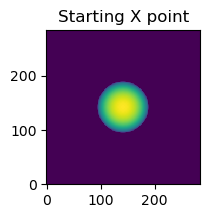

In [18]:
## First find the cartestian points of the reference point for the line of sight
## in the observer's geometry.  For offlimb points, this is the plane of the sky (yz). 
## On disk, these points should lie on the solar surface
xxObs = np.zeros_like(yya)
yyObs = rObs * np.tan(np.deg2rad(yya/3600.))
zzObs = rObs * np.tan(np.deg2rad(zza/3600.))
rrObs = np.sqrt(yyObs**2 + zzObs**2)
xxObs[rrObs<1] = np.sqrt(1 - rrObs[rrObs<1]**2) 
plt.figure(figsize = (2.5,2))
plt.imshow(xxObs)
plt.title('Starting X point')

In [19]:
## rotate these points into the model geometry with Euler rotation
rotm = euler_ry((thetaObs-np.pi/2.)) @ euler_rz(phiObs)
## earlier I had the rotation matrix as the transpose...not sure why..incorrect?
xyz_model = rotm  @ np.stack((xxObs.flatten(),yyObs.flatten(),zzObs.flatten())) 

## NOW WITH THE XYZ_MODEL POINTS AND THE LOCATION OF THE OBSERVER IN MODEL FRAME
## come up with the parametric equations for the los of sight
losvec    = np.stack((xObs-xyz_model[0,:],yObs-xyz_model[1,:],zObs - xyz_model[2,:]))
losveclen = np.linalg.norm(losvec,axis=0,ord=2,keepdims = True)
losvec    = losvec / losveclen
startpt   = xyz_model

In [20]:
lons,lats,rs = corona.lons,corona.lats,corona.rs
deltaR = (np.roll(rs,-1) - rs)[:(-1)]     ## using the radial sampling of the PSI model as the step size for the integration
deltaR = np.cumsum(deltaR)
deltaR = np.hstack((-np.flip(deltaR),deltaR))  ## both directions

In [21]:
rays_xyz = startpt[None,:,:] + (losvec * deltaR[:,None,None])
rays_xyz = np.swapaxes(rays_xyz,1,2)
print(rays_xyz.shape)

(298, 81225, 3)


In [22]:
nrays   = startpt.shape[1]
ray_npt = len(deltaR)
print('Number of rays to trace: ',nrays) 
print('Max number of samples per ray: ',ray_npt)

Number of rays to trace:  81225
Max number of samples per ray:  298


In [23]:
## get spherical coordinates of rays
rays_sph = np.zeros_like(rays_xyz)
rays_sph[:,:,0] = np.linalg.norm(rays_xyz,axis=2)        ## l2-norm 
rays_sph[:,:,1] = np.arccos(rays_xyz[:,:,2] / rays_sph[:,:,0])   ## arccos (z / r) 
rays_sph[:,:,2] = np.arctan2(rays_xyz[:,:,1] , rays_xyz[:,:,0])   ## arctan (y / x) 
rays_sph[:,:,2][rays_sph[:,:,2] <0] += 2.*np.pi ## so that it falls in the simulation domain 

In [24]:
print(startpt.shape,rays_sph.shape,rays_xyz.shape)
print(np.max(deltaR))

(3, 81225) (298, 81225, 3) (298, 81225, 3)
29.0


In [25]:
if 0: 
    print(rays_sph.shape)
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(rays_xyz[0,::10,0],rays_xyz[0,::10,1],rays_xyz[0,::10,2])
    ax.scatter3D(rays_xyz[ray_npt//2,::10,0],rays_xyz[ray_npt//2,::10,1],rays_xyz[ray_npt//2,::10,2])
    ax.scatter3D(rays_xyz[-1,::10,0],rays_xyz[-1,::10,1],rays_xyz[-1,::10,2])

    ax.scatter3D(xObs,yObs,zObs,'x',color = 'black') ## cartesian position of Observer in PSI model geometery (units of solar radii)
    ax.plot3D([0,xObs],[0,yObs],[0,zObs],ls = 'dashdot',color  = 'black')
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_zlim(-5,5)

    plt.figure(figsize = (6,4))
    plt.scatter(rays_xyz[ray_npt//2,:,2], rays_xyz[ray_npt//2,:,1],c=rays_sph[ray_npt//2,:,0],s=0.5)  ## lons, lats
    plt.ylim(-1,1)

## **Interpolate model variables at ray samples**

In [26]:
rays_xyz = rays_xyz.reshape(ray_npt*nrays,3)
rays_sph = rays_sph.reshape(ray_npt*nrays,3)

In [27]:
#### Get interpolating functions for all necessary simulation data
#### the ccoefInt already has the density factors included
ccoef1Int = rgi((lons,lats,rs),ccoef_10747,method = 'linear',fill_value = 0.,bounds_error = False)
align1Int = rgi((lons,lats,rs),align_10747,method = 'linear',fill_value = 0.,bounds_error = False)
bxInt    = rgi((lons,lats,rs),corona.bx,method = 'linear',fill_value = 0.,bounds_error = False)
byInt    = rgi((lons,lats,rs),corona.by,method = 'linear',fill_value = 0.,bounds_error = False)
bzInt    = rgi((lons,lats
                ,rs),corona.bz,method = 'linear',fill_value = 0.,bounds_error = False)
tempInt  = rgi((lons,lats,rs),corona.temp,method = 'linear',fill_value = 0.,bounds_error = False)
neInt    = rgi((lons,lats,rs),corona.ne,method = 'linear',fill_value = 0.,bounds_error = False)

In [28]:
def parallel_int(argin):
    iobj,i0,i1 = argin
    return iobj(rays_sph[i0:i1,::-1])
        
def interpolate_raypts(iobj_int): 
                       
    nproc = 20
    nptint = ray_npt*nrays
    nrays_per_proc = np.ceil(nptint/nproc).astype(int)
    args = []
    for n in range(nproc):
        i0,i1 = n*nrays_per_proc,  (n+1)*nrays_per_proc
        i1 = np.clip(i1,0,nptint)
        args.append((iobj_int,i0,i1))
    
    p =  multiprocessing.Pool(processes=nproc,maxtasksperchild = 1000) 
    rs = p.imap(parallel_int,args)
    p.close()
    
    var_rays = np.zeros(nptint)
    
    nargs = len(args)
    pbar = tqdm.tqdm(total=nargs, position=0, leave=True)
    for i,res in enumerate(rs):
        i0,i1 = args[i][1:]
        var_rays[i0:i1] = res 
        pbar.update()
    pbar.close()

    return var_rays

In [29]:
## get bx,by,bz in PSI geometry for all the ray points
## this is the step that takes the longest! 
bx_rays = interpolate_raypts(bxInt)
by_rays = interpolate_raypts(byInt)
bz_rays = interpolate_raypts(bzInt)
temp_rays = interpolate_raypts(tempInt)
ne_rays = interpolate_raypts(neInt)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.15it/s]


In [30]:
ccoef1_rays = interpolate_raypts(ccoef1Int) 
align1_rays = interpolate_raypts(align1Int) 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.43it/s]


In [31]:
ccoef1_rays = ccoef1_rays.reshape(ray_npt,nrays)
align1_rays = align1_rays.reshape(ray_npt,nrays)
temp_rays = temp_rays.reshape(ray_npt,nrays)
ne_rays = ne_rays.reshape(ray_npt,nrays)

In [32]:
rays_xyz = rays_xyz.reshape(ray_npt,nrays,3)
rays_sph = rays_sph.reshape(ray_npt,nrays,3)

In [33]:
## calculate the magnetic field inclination angle wrt the line-of-sight 
bxyzs = np.stack((bx_rays,by_rays,bz_rays)).T
blens = np.linalg.norm(bxyzs,axis =1)
bxyzs = bxyzs.reshape(ray_npt,nrays,3)
blens = blens.reshape(ray_npt,nrays)
thetaBlos = np.arccos( (np.sum(bxyzs*losvec.T[None,:,:],axis=2)/blens).clip(min = -1,max=1))
thetaBlos[np.isnan(thetaBlos)] = 0.

/tmp/ipykernel_2494530/3178097367.py:6: RuntimeWarning: invalid value encountered in divide
  thetaBlos = np.arccos( (np.sum(bxyzs*losvec.T[None,:,:],axis=2)/blens).clip(min = -1,max=1))


In [34]:
## angle between losvec and the vector from disk center
thetaDClos = np.arccos( (np.sum(rays_xyz*losvec.T[None,:,:],axis=2)/rays_sph[:,:,0]).clip(min = -1,max=1))

In [35]:
## get projection of B onto plane perpendicular to LOS
## and the projection of DC vector onto same plane
Bperp  = bxyzs - (blens*np.cos(thetaBlos))[:,:,None] * losvec.T[None,:,:]
DCperp = rays_xyz - (rays_sph[:,:,0]*np.cos(thetaDClos))[:,:,None] * losvec.T[None,:,:]

In [36]:
## find angle between Bperp and DCperp, which is the azimuthal angle relative to disk center
costhetaAzi = np.sum((Bperp*DCperp),axis=2)/(np.linalg.norm(Bperp,axis = 2)*np.linalg.norm(DCperp,axis = 2))
del Bperp
del DCperp
thetaAzi = np.arccos(costhetaAzi.clip(min =-1,max=1))
thetaAzi[np.isnan(thetaAzi)] = 0.
del costhetaAzi

/tmp/ipykernel_2494530/3888707345.py:2: RuntimeWarning: invalid value encountered in divide
  costhetaAzi = np.sum((Bperp*DCperp),axis=2)/(np.linalg.norm(Bperp,axis = 2)*np.linalg.norm(DCperp,axis = 2))


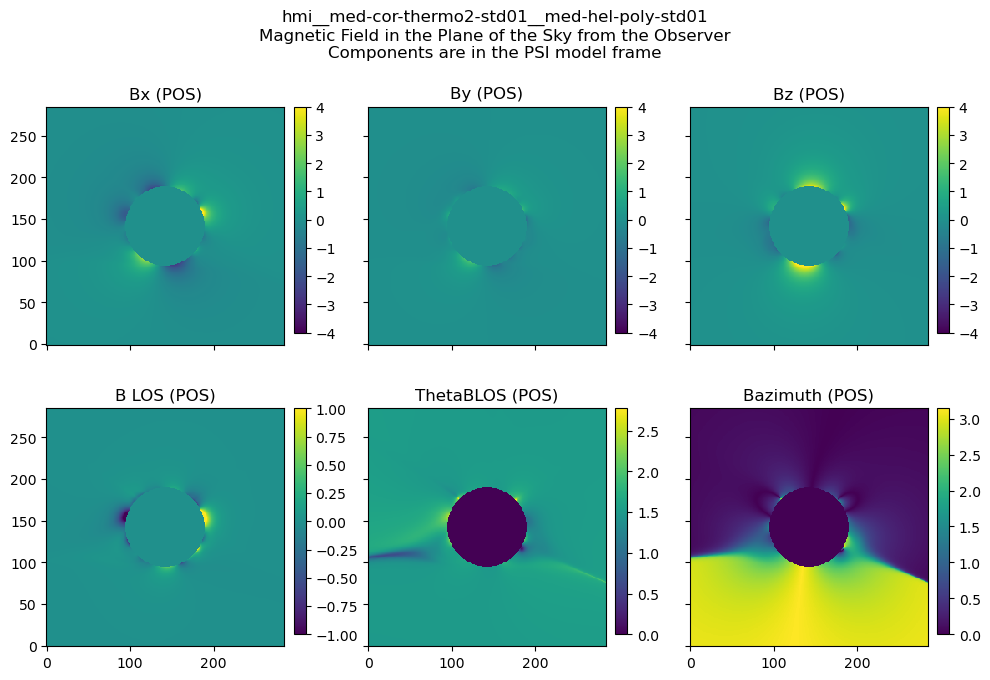

In [37]:
fig,ax = plt.subplots(2,3,figsize = (10,7),sharex=True,sharey=True)
ax = ax.flatten()
im0 = ax[0].imshow(bx_rays.reshape(ray_npt,nrays)[ray_npt//2,:].reshape(*yya.shape)*mask_ondisk)
im1 = ax[1].imshow(by_rays.reshape(ray_npt,nrays)[ray_npt//2,:].reshape(*yya.shape)*mask_ondisk)
im2 = ax[2].imshow(bz_rays.reshape(ray_npt,nrays)[ray_npt//2,:].reshape(*yya.shape)*mask_ondisk)

im3 = ax[3].imshow(blens[ray_npt//2,:].reshape(*yya.shape) * np.cos(thetaBlos[ray_npt//2,:].reshape(*yya.shape))*mask_ondisk)
im4 = ax[4].imshow(thetaBlos[ray_npt//2,:].reshape(*yya.shape)*mask_ondisk)
im5 = ax[5].imshow(thetaAzi[ray_npt//2,:].reshape(*yya.shape)*mask_ondisk)
for im in im0,im1,im2,: im.set_clim(-4,4)
im3.set_clim(-1,1)

labs = 'Bx (POS)','By (POS)','Bz (POS)','B LOS (POS)','ThetaBLOS (POS)','Bazimuth (POS)'
for n in range(6): ax[n].set_title(labs[n])

cbars = []
for axi in ax:
 cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
 cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
 cbars.append(cbar1)

fig.suptitle(modelName + '\nMagnetic Field in the Plane of the Sky from the Observer\nComponents are in the PSI model frame') 

fig.tight_layout()

1778279.410038923


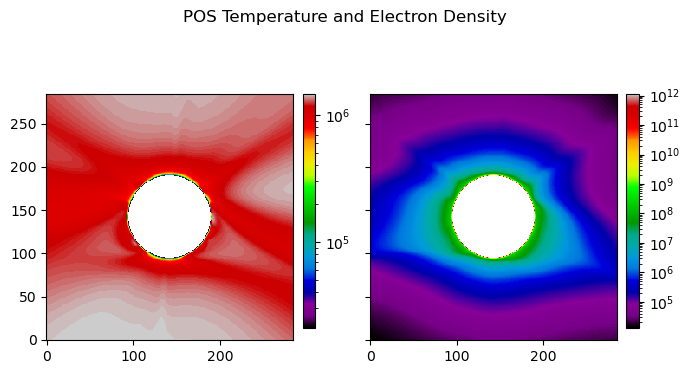

In [38]:
fig,ax = plt.subplots(1,2,figsize = (7,4),sharex=True,sharey=True)
ax = ax.flatten()
im0 = ax[0].imshow(temp_rays.reshape(ray_npt,nrays)[ray_npt//2,:].reshape(*yya.shape)*mask_ondisk,norm = LogNorm(),cmap = plt.get_cmap('nipy_spectral'))
im1 = ax[1].imshow(ne_rays.reshape(ray_npt,nrays)[ray_npt//2,:].reshape(*yya.shape)*mask_ondisk,norm = LogNorm(),cmap = plt.get_cmap('nipy_spectral'))

print(10.**6.25)

cbars = []
for axi in ax:
 cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
 cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
 cbars.append(cbar1)

fig.suptitle('POS Temperature and Electron Density')
fig.tight_layout()

## Forward Synthesize the Thomson Scattering

In [39]:
ht = (rays_sph[:,:,0]-1).clip(1.e-8) * constants.radius.value/1000.
ht = ht.reshape(ray_npt*nrays)
## CENTER PASSBAAND OF MLSO/COSMO/K-COR IS AT 7350 Angstrom 
## here using 10747 for Cryo Observations
J00 = allen.J00_sym(10747.,ht) 
units = J00[1]
print(units)
J00 = J00[0]
omega = allen.get_omega(10747.,ht)
Idc, Idc_unit = allen.i_nu(10747.,1.)

erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ Hz$^{-1}$


In [40]:
J00 = J00.reshape(ray_npt,nrays)
omega = omega.reshape(ray_npt,nrays)

In [41]:
## distance vector along the ray 
dray = deltaR[:,None] * constants.radius.value*100.  ## cm 
drayg = np.gradient(dray[:,0])

In [42]:
cc = 0.665e-24  ## total thomson scattering crosssection; units:: cm^2
## emission coefficients along line of sight (Equation 20 in Schad et al. 2022)
eps_rays = cc * ne_rays * J00 * (1 + omega/2 - (3./4.)*omega*np.sin(thetaDClos)**2)
Ithomson = np.trapz(eps_rays,dray,axis=0).reshape(*yya.shape) * mask_ondisk / Idc *1e6  ## millionths of DC radiance 
eps_rays = - 3./4. * cc * ne_rays * omega * J00 * np.sin(thetaDClos)**2
pBthomson = np.trapz(eps_rays,dray,axis=0).reshape(*yya.shape) * mask_ondisk / Idc *1e6 ## millionths of DC radiance 

/tmp/ipykernel_2494530/286178400.py:5: RuntimeWarning: invalid value encountered in divide
  im2 = ax[2].imshow(-pBthomson/Ithomson,cmap = plt.get_cmap('nipy_spectral'))


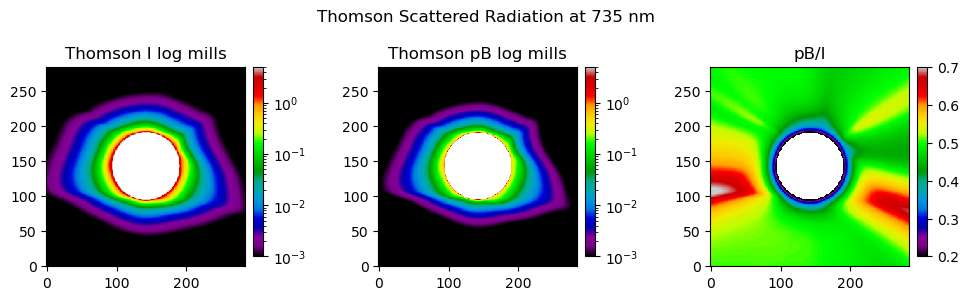

In [43]:
fig,ax = plt.subplots(1,3,figsize = (10,3.) )
ax = ax.flatten()
im0 = ax[0].imshow(Ithomson,norm = LogNorm(),cmap = plt.get_cmap('nipy_spectral'))
im1 = ax[1].imshow(-pBthomson,norm = LogNorm(),cmap = plt.get_cmap('nipy_spectral'))
im2 = ax[2].imshow(-pBthomson/Ithomson,cmap = plt.get_cmap('nipy_spectral'))
im0.set_clim(0.001,5)
im1.set_clim(0.001,5)
im2.set_clim(0.2,0.7)

cbars = []
for axi in ax:
 cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
 cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
 cbars.append(cbar1)

ax[0].set_title('Thomson I log mills')
ax[1].set_title('Thomson pB log mills')
ax[2].set_title('pB/I')

fig.suptitle('Thomson Scattered Radiation at 735 nm')
fig.tight_layout()

In [44]:
## weight temp and ne by thomson scattered signal? 
cc = 0.665e-24  ## total thomson scattering crosssection
eps_rays = cc * ne_rays * J00 * (1 + omega/2 - (3./4.)*omega*np.sin(thetaDClos)**2)
wgtTemp = np.trapz(temp_rays*eps_rays,dray,axis=0).reshape(*yya.shape) / np.trapz(eps_rays,dray,axis=0).reshape(*yya.shape)
wgtNe  = np.trapz(ne_rays*eps_rays,dray,axis=0).reshape(*yya.shape) / np.trapz(eps_rays,dray,axis=0).reshape(*yya.shape)

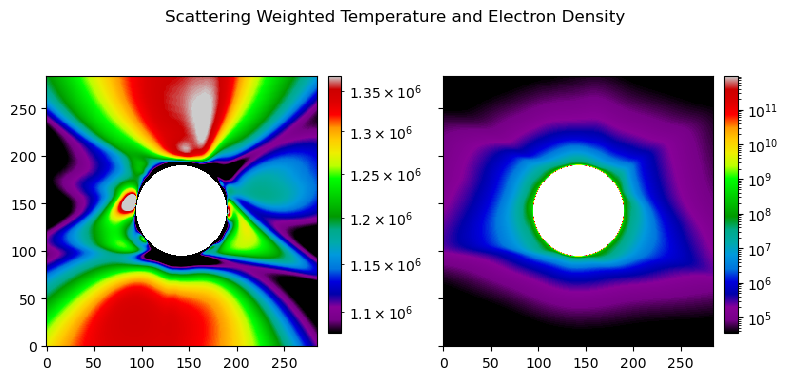

In [45]:
fig,ax = plt.subplots(1,2,figsize = (8,4),sharex=True,sharey=True)
ax = ax.flatten()

im0 = ax[0].imshow(wgtTemp.reshape(*yya.shape) * mask_ondisk,norm = LogNorm(),cmap = plt.get_cmap('nipy_spectral'))
im1 = ax[1].imshow(wgtNe.reshape(*yya.shape) * mask_ondisk,norm = LogNorm(),cmap = plt.get_cmap('nipy_spectral'))
im0.set_clim(np.nanpercentile(wgtTemp,[15,99]))
im1.set_clim(np.nanpercentile(wgtNe,[15,99]))

cbars = []
for axi in ax:
 cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
 cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
 cbars.append(cbar1)

fig.suptitle('Scattering Weighted Temperature and Electron Density')
fig.tight_layout()

## **Forward Synthesize Emission Line** 

In [46]:
## distance vector along the ray 
dray = deltaR[:,None] * constants.radius.value*100.  ## cm 
drayg = np.gradient(dray[:,0])

Recall that in https://github.com/tschad/pycelp/blob/polEmiss_examples/pycelp/emissionLine.py

self.C_coeff =   self.hnu/4./np.pi * self.Einstein_A * self.upper_level_pop_frac * self.total_ion_population

See equation 3, 5,7,8 in Schad & Dima (2020)

In [47]:
geff,D_coeff,E_coeff = fe13_ln1.geff,fe13_ln1.Dcoeff,fe13_ln1.Ecoeff
cc = 2.99792458e10 ## cm s^-1 (speed of light)
wv_vac_cm = fe13_ln1.wavelength_in_vacuum * 1.e-8 
Vscl   = - (wv_vac_cm)**2 / cc * 1.e8 ## units of Angstrom *s 
epsI   = ccoef1_rays*(1.0+(1./(2.*np.sqrt(2.)))*(3.*np.cos(thetaBlos)**2 - 1.)*D_coeff*align1_rays)
epsQnr = ccoef1_rays*(3./(2.*np.sqrt(2.)))*(np.sin(thetaBlos)**2)*D_coeff*align1_rays
epsQ   = np.cos(2.*thetaAzi)*epsQnr
epsU   = -np.sin(2.*thetaAzi)*epsQnr
epsV   = Vscl* ccoef1_rays*np.cos(thetaBlos)*(1399612.2*blens)*(geff + E_coeff*align1_rays)
epsI_int1 = np.trapz(epsI,dray,axis=0).reshape(*yya.shape) * mask_ondisk
epsQ_int1 = np.trapz(epsQ,dray,axis=0).reshape(*yya.shape) * mask_ondisk
epsU_int1 = np.trapz(epsU,dray,axis=0).reshape(*yya.shape) * mask_ondisk
epsV_int1 = np.trapz(epsV,dray,axis=0).reshape(*yya.shape) * mask_ondisk
ne_wgtI1 = np.sum(epsI*ne_rays*drayg[:,None],axis=0)    ## volumetric weighted? 
ne_wgtI1 /= np.sum(epsI*drayg[:,None],axis=0)
ne_wgtI1 = ne_wgtI1.reshape(*yya.shape)*mask_ondisk

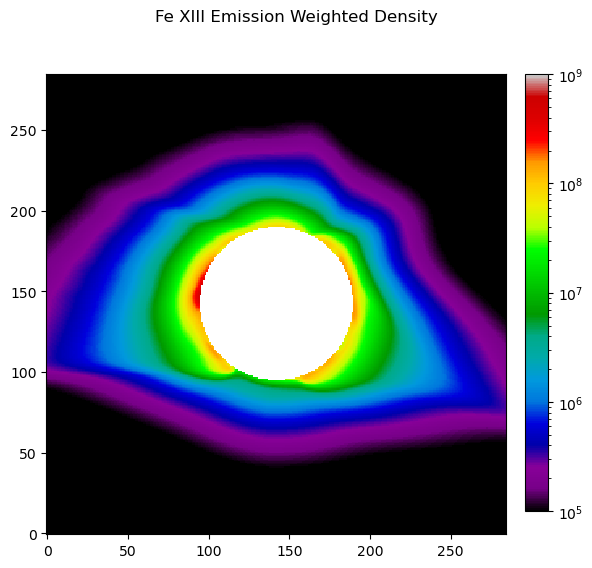

In [48]:
fig,axi = plt.subplots(1,1,figsize = (6,6) )
axi.imshow(ne_wgtI1,norm = LogNorm(),cmap = plt.get_cmap('nipy_spectral'))
imn = axi.get_images()[0]
imn.set_clim(1e5,1e9)
cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)

fig.suptitle('Fe XIII Emission Weighted Density')
fig.tight_layout()

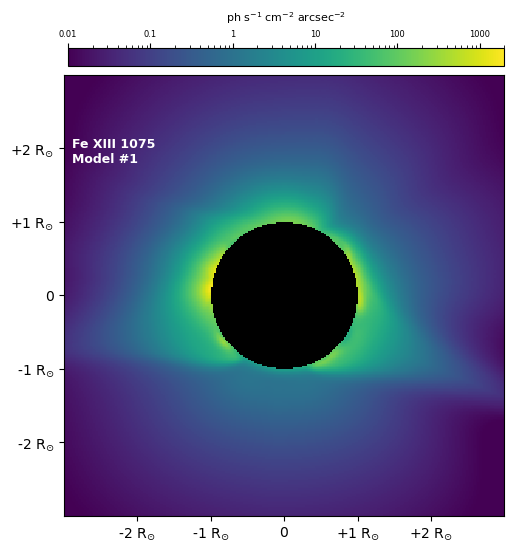

In [50]:
fig,axi = plt.subplots(1,1,figsize = (5,6),sharex=True,sharey=True) 

sr2arcsec = (180./np.pi)**2.*3600.**2.
hh        = 6.6260755e-27                  ## erg s

cm = 'nipy_spectral'
cm = plt.get_cmap('viridis').copy()
cm.set_bad('k')
extimg = (yya[0,0]/rsunarc,yya[0,-1]/rsunarc,zza[0,0]/rsunarc,zza[-1,0]/rsunarc)

phergs1    = hh*(3.e8)/(10747.0e-10)      ## ergs to photons
img = epsI_int1/sr2arcsec/phergs1  * 3.98 ## scale for coronal abund since pycelp assumed photospheric above
im0 = axi.imshow(img,norm = LogNorm(),cmap = cm,extent = extimg)

im0.set_clim(0.01,2000.)

from matplotlib.ticker import ScalarFormatter
cax = axi.inset_axes([0.01, 1.02, 0.99, 0.04], transform=axi.transAxes)
cb = fig.colorbar(im0,ax=axi,cax=cax,orientation = 'horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
cb.ax.set_title(r'ph s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$',fontsize=8)
cb.ax.xaxis.set_ticks([0.01,0.1,1,10,100,1000])
cb.ax.xaxis.set_ticklabels(['0.01','0.1','1','10','100','1000'])
cb.ax.tick_params(labelsize=6) 

labels = 'Fe XIII 1075'
axi.text(0.02,0.8,labels + '\nModel #1',transform = axi.transAxes,color = 'white',fontsize = 9,fontweight = 'bold')

axi.set_yticks((-2,-1,0,1,2))
axi.set_xticks((-2,-1,0,1,2))

labels = [item.get_text() for item in axi.get_xticklabels()]
labels[0] = r'-2 R$_{\odot}$'
labels[1] = r'-1 R$_{\odot}$'
labels[2] = r'0'
labels[3] = r'+1 R$_{\odot}$'
labels[4] = r'+2 R$_{\odot}$'

axi.set_xticklabels(labels)
labels = [item.get_text() for item in axi.get_yticklabels()]
labels[0] = r'-2 R$_{\odot}$'
labels[1] = r'-1 R$_{\odot}$'
labels[2] = r'0'
labels[3] = r'+1 R$_{\odot}$'
labels[4] = r'+2 R$_{\odot}$'

axi.set_yticklabels(labels)

fig.tight_layout(pad = 0.2)


/tmp/ipykernel_2494530/1762355804.py:3: RuntimeWarning: divide by zero encountered in log10
  im0 = ax[0].imshow(np.log10(epsI_int1))
/tmp/ipykernel_2494530/1762355804.py:4: RuntimeWarning: divide by zero encountered in log10
  im1 = ax[1].imshow(np.log10(np.sqrt(epsQ_int1**2. + epsU_int1**2)))
/tmp/ipykernel_2494530/1762355804.py:5: RuntimeWarning: invalid value encountered in divide
  im2 = ax[2].imshow(np.sqrt(epsQ_int1**2. + epsU_int1**2)/epsI_int1)


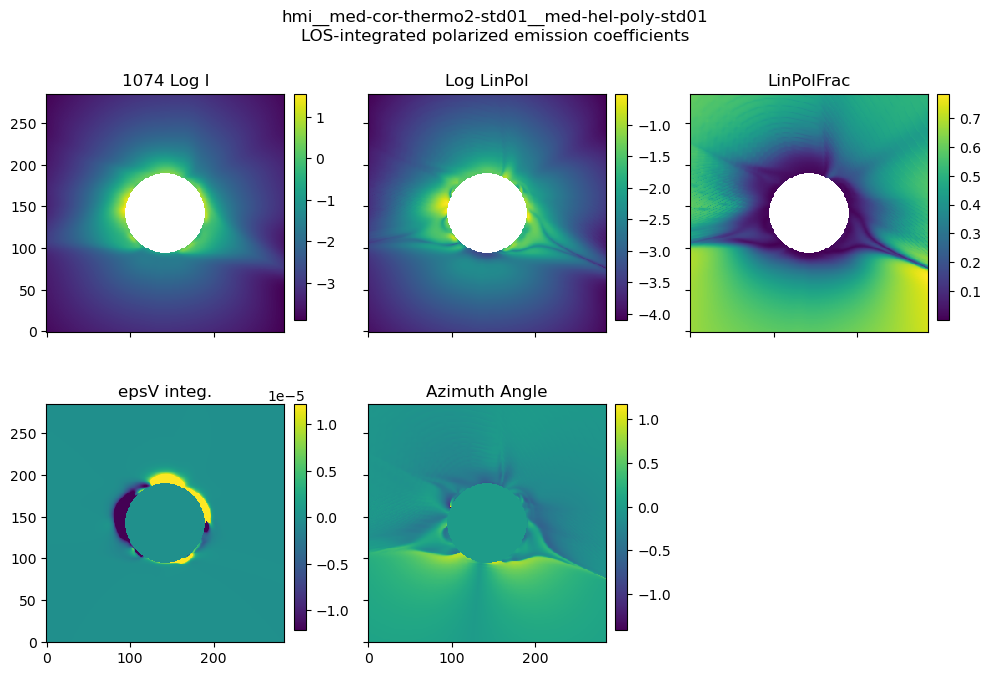

In [51]:
fig,ax = plt.subplots(2,3,figsize = (10,7),sharex=True,sharey=True)
ax = ax.flatten()
im0 = ax[0].imshow(np.log10(epsI_int1))
im1 = ax[1].imshow(np.log10(np.sqrt(epsQ_int1**2. + epsU_int1**2)))
im2 = ax[2].imshow(np.sqrt(epsQ_int1**2. + epsU_int1**2)/epsI_int1)
im3 = ax[3].imshow(epsV_int1)
mrang = np.max(np.abs(np.percentile(epsV_int1,[1,99])))
im3.set_clim(-mrang,mrang)

im4 = ax[4].imshow(0.5*np.arctan2(epsU_int1 , epsQ_int1)*mask_ondisk)

labs = '1074 Log I','Log LinPol','LinPolFrac','epsV integ.','Azimuth Angle'
for n in range(5): ax[n].set_title(labs[n])

ax[-1].axis('off')

cbars = []
for axi in ax[:-1]:
 cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
 cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
 cbars.append(cbar1)

fig.suptitle(modelName + '\nLOS-integrated polarized emission coefficients') 

fig.tight_layout()

## Stokes Spectra Generation for 1074

In [52]:
geff,D_coeff,E_coeff = fe13_ln1.geff,fe13_ln1.Dcoeff,fe13_ln1.Ecoeff
cc = 2.99792458e10 ## cm s^-1 (speed of light)
wv_vac_cm = fe13_ln1.wavelength_in_vacuum * 1.e-8 
Vscl   = - (wv_vac_cm)**2 / cc * 1.e8 ## units of Angstrom *s 
epsI   = ccoef1_rays*(1.0+(1./(2.*np.sqrt(2.)))*(3.*np.cos(thetaBlos)**2 - 1.)*D_coeff*align1_rays)
epsQnr = ccoef1_rays*(3./(2.*np.sqrt(2.)))*(np.sin(thetaBlos)**2)*D_coeff*align1_rays
epsQ   = np.cos(2.*thetaAzi)*epsQnr
epsU   = -np.sin(2.*thetaAzi)*epsQnr
epsV   = Vscl* ccoef1_rays*np.cos(thetaBlos)*(1399612.2*blens)*(geff + E_coeff*align1_rays)

In [53]:
#epsV   = Vscl*ccoef2_rays*np.cos(thetaBlos)*(1399612.2*blens)*(geff + E_coeff*align2_rays)
#epsV_int2 = np.trapz(epsV,dray,axis=0).reshape(*yya.shape) * mask_ondisk
epsV.shape

(298, 81225)

In [54]:
epsV_re = epsV.reshape(epsV.shape[0],*yya.shape)
epsV_re.shape

(298, 285, 285)

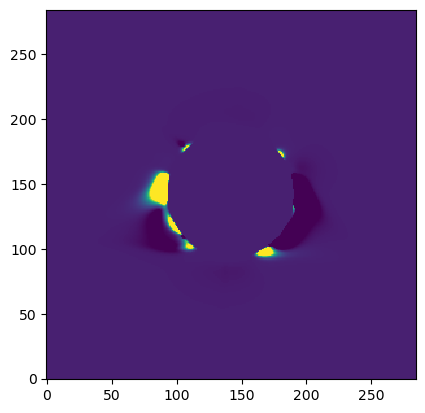

In [55]:
plt.figure()
rsamp = epsV_re.shape[0]//2 + 0
plt.imshow(epsV_re[rsamp,:,:])
plt.clim(-np.nanpercentile(np.abs(epsV_re[rsamp,:,:]),[97]),np.nanpercentile(np.abs(epsV_re[rsamp,:,:]),[99]))

In [56]:
blens.shape,thetaBlos.shape

((298, 81225), (298, 81225))

In [57]:
ht = (rays_sph[:,:,0]-1).clip(1.e-8)
ht.shape

(298, 81225)

In [58]:
yya.shape

(285, 285)

In [59]:
sr2arcsec = (180./np.pi)**2.*3600.**2.
hh = 6.626176e-27  ## ergs sec (planck's constant);
phergs = hh*(3.e8)/(fe13_ln1.wavelength_in_vacuum * 1.e-10)

epsI = epsI/sr2arcsec/phergs        
epsQ = epsQ/sr2arcsec/phergs        
epsU = epsU/sr2arcsec/phergs        
epsV = epsV/sr2arcsec/phergs        

In [60]:
doppler_velocity = 0.
non_thermal_turb_velocity = 0.
doppler_spectral_range = (-120,120)
specRes_wv_over_dwv = 100000

dVel = 3e5 / specRes_wv_over_dwv
nwv = np.ceil((doppler_spectral_range[1] - doppler_spectral_range[0]) / dVel).astype(int)
velvec = np.linspace(*doppler_spectral_range,nwv)  ##;; velocity range used for the spectral axis
wvvec = (fe13_ln1.wavelength_in_air  *1.e-10)*(1. + velvec/3.e5)  ## in units of meters at this point 

In [61]:
awgt = fe13_ln1.atomic_weight
M = (awgt*1.6605655e-24)/1000.   ## kilogram
kb = 1.380648e-23  ## J K^-1 [ = kg m^2 s^-2 K^-1]
etemp = temp_rays
turbv = non_thermal_turb_velocity
sig = (1./np.sqrt(2.))*(fe13_ln1.wavelength_in_air*1.e-10/3.e8)*np.sqrt(2.*kb*etemp/M + (turbv*1000.)**2.)

In [62]:
## calculate line center position 
wv0 = (fe13_ln1.wavelength_in_air*1.e-10) + (doppler_velocity/3.e5)*(fe13_ln1.wavelength_in_air*1.e-10)    ## in meters 
wv0 = wv0*1.e10     ## convert to Angstrom 
sig = sig*1.e10      ## convert to Angstrom 
wvvec = wvvec*1.e10  ## convert to Angstrom 

15767.0


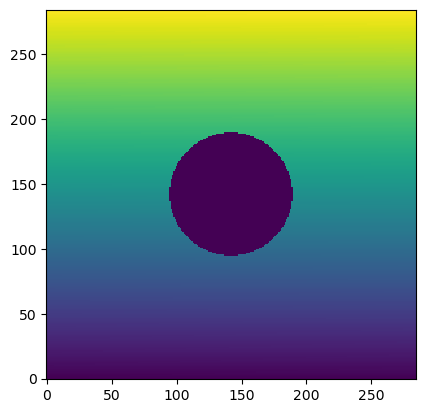

In [63]:
plt.figure()
pixv = (np.arange(nrays).reshape(*yya.shape) * mask_ondisk)
plt.imshow(pixv)
print(pixv[55,92])

In [64]:
%%time 
iray = 10487
wprof_iray = (1./(np.sqrt(2.*np.pi)*sig[:,iray])) * np.exp(-(wvvec[:,None]-wv0)**2./(2.*sig[:,iray][None,:]**2.))
wprof_deriv_iray =  (- (wvvec[:,None]-wv0) / sig[:,iray][None,:]**2)  * wprof_iray 

stokes = np.zeros((len(wvvec),4))
stokes[:,0] = np.trapz(epsI[:,iray][None,:] * wprof_iray,dray[:,0],axis=1)
stokes[:,1] = np.trapz(epsQ[:,iray][None,:] * wprof_iray,dray[:,0],axis=1)
stokes[:,2] = np.trapz(epsU[:,iray][None,:] * wprof_iray,dray[:,0],axis=1)
stokes[:,3] = np.trapz(epsV[:,iray][None,:] * wprof_deriv_iray,dray[:,0],axis=1)

CPU times: user 1.53 ms, sys: 0 ns, total: 1.53 ms
Wall time: 1.22 ms


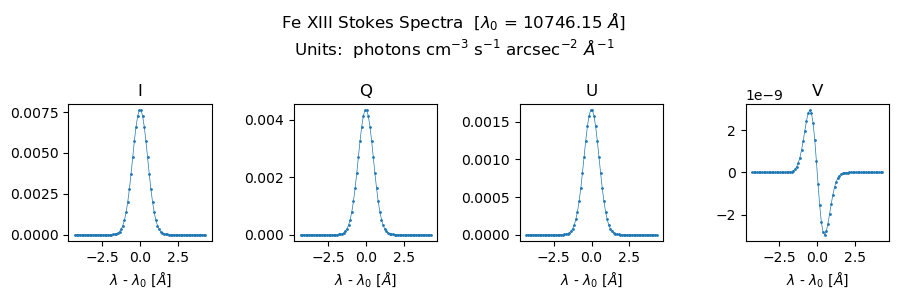

In [65]:
fig,ax = plt.subplots(1,4,figsize = (9,3),sharex=True)
ax = ax.flatten()
labels = 'I','Q','U','V'
for n in range(4): 
    ax[n].plot(wvvec -fe13_ln1.wavelength_in_air,stokes[:,n],'.-',lw = 0.5,markersize = 2)
    ax[n].set_title(labels[n])
    ax[n].set_xlabel(r'$\lambda$ - $\lambda_0$ [$\AA$]')
fig.suptitle('Fe XIII Stokes Spectra  [' + r'$\lambda_0$ = ' + str(np.round(fe13_ln1.wavelength_in_air,2)) + r' $\AA$' + ']\n' + 
             r'Units:  photons cm$^{-3}$ s$^{-1}$ arcsec$^{-2}$ $\AA^{-1}$')
fig.tight_layout()

## Generate stokes spectra

In [66]:
stokes = np.zeros((nrays,len(wvvec),4))

for iray in trange(nrays): 
    wprof_iray = (1./(np.sqrt(2.*np.pi)*sig[:,iray])) * np.exp(-(wvvec[:,None]-wv0)**2./(2.*sig[:,iray][None,:]**2.))
    wprof_deriv_iray =  (- (wvvec[:,None]-wv0) / sig[:,iray][None,:]**2)  * wprof_iray 
    
    stokes[iray,:,0] = np.trapz(epsI[:,iray][None,:] * wprof_iray,dray[:,0],axis=1)
    stokes[iray,:,1] = np.trapz(epsQ[:,iray][None,:] * wprof_iray,dray[:,0],axis=1)
    stokes[iray,:,2] = np.trapz(epsU[:,iray][None,:] * wprof_iray,dray[:,0],axis=1)
    stokes[iray,:,3] = np.trapz(epsV[:,iray][None,:] * wprof_deriv_iray,dray[:,0],axis=1)

  0%|          | 0/81225 [00:00<?, ?it/s]

/tmp/ipykernel_2494530/1767541552.py:4: RuntimeWarning: divide by zero encountered in divide
  wprof_iray = (1./(np.sqrt(2.*np.pi)*sig[:,iray])) * np.exp(-(wvvec[:,None]-wv0)**2./(2.*sig[:,iray][None,:]**2.))
/tmp/ipykernel_2494530/1767541552.py:4: RuntimeWarning: invalid value encountered in multiply
  wprof_iray = (1./(np.sqrt(2.*np.pi)*sig[:,iray])) * np.exp(-(wvvec[:,None]-wv0)**2./(2.*sig[:,iray][None,:]**2.))
/tmp/ipykernel_2494530/1767541552.py:5: RuntimeWarning: divide by zero encountered in divide
  wprof_deriv_iray =  (- (wvvec[:,None]-wv0) / sig[:,iray][None,:]**2)  * wprof_iray


In [67]:
stokes.shape

(81225, 80, 4)

In [68]:
Idc, Idc_unit = allen.i_lambda(10747.,1.)
print(Idc,Idc_unit)
Idc_ph = Idc/sr2arcsec/phergs
print(Idc/sr2arcsec/phergs    )

1073250.0 erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ $\AA^{-1}$
13640764.768267948


In [69]:
stokes.shape

(81225, 80, 4)

In [70]:
mp = np.max(stokes[:,40:,3],axis=1)
mn = np.max(-stokes[:,40:,3],axis=1)
mm = np.zeros_like(mp)
mm[mp>mn] = mp[mp>mn]
mm[mn>=mp] = -mn[mn>=mp]

Text(0.5, 1.0, 'Stokes V in millionths')

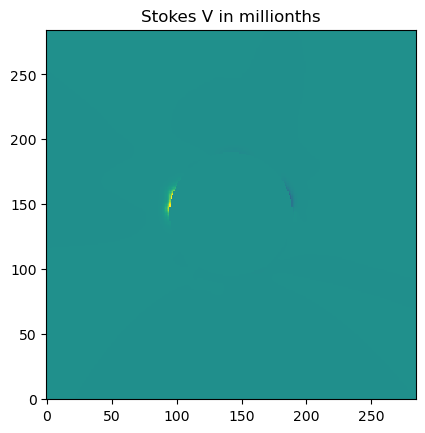

In [71]:
plt.figure()
plt.imshow(mm.reshape(*yya.shape) * mask_ondisk / Idc_ph*1e6)
plt.clim(-0.005,0.005)
plt.title('Stokes V in millionths')

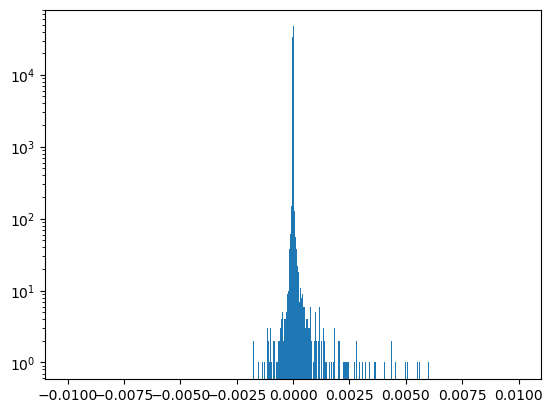

In [72]:
plt.figure()
hh = plt.hist((mm.reshape(*yya.shape) * mask_ondisk / Idc_ph*1e6).flatten(),range=(-0.01,0.01),bins = 500)
plt.yscale('log')

## Derive a LOS V "magnetogram"


In [73]:
stokes.shape

(81225, 80, 4)

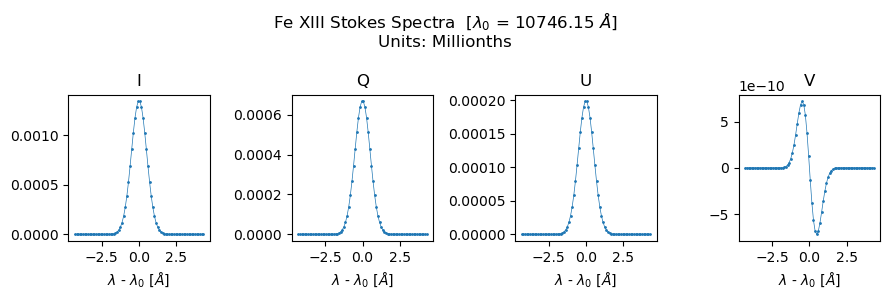

In [74]:
fig,ax = plt.subplots(1,4,figsize = (9,3),sharex=True)
ax = ax.flatten()
labels = 'I','Q','U','V'
iray= np.ravel_multi_index([40,90],yya.shape)
#iray= np.ravel_multi_index([54,95],yya.shape)
for n in range(4): 
    ax[n].plot(wvvec -fe13_ln1.wavelength_in_air,stokes[iray,:,n] / Idc_ph *1e6,'.-',lw = 0.5,markersize = 2)
    ax[n].set_title(labels[n])
    ax[n].set_xlabel(r'$\lambda$ - $\lambda_0$ [$\AA$]')
fig.suptitle('Fe XIII Stokes Spectra  [' + r'$\lambda_0$ = ' + str(np.round(fe13_ln1.wavelength_in_air,2)) + r' $\AA$' + ']\n' + 
             r'Units: Millionths')
fig.tight_layout()

### Weak field approximation

In [75]:
#wvvac = ln.wavelength_in_vacuum
#geff = ln.geff
#dlambdaB = 4.6686e-10 * (wvvac**2) * magnetic_field_amplitude  / 1000. 
#V_WFA = - dlambdaB * geff * np.cos(np.deg2rad(thetaBLOSdeg)) * np.gradient(stokes[iray,:,n],wvvec) 

In [76]:
## sample ray 
iray= np.ravel_multi_index([25,25],yya.shape)

In [77]:
Vf_over_blos = - 4.6686e-10 * (wvvec.mean()**2) /1000. * fe13_ln1.geff *  np.gradient(stokes[iray,:,0],wvvec)  

0.0006486941231894152


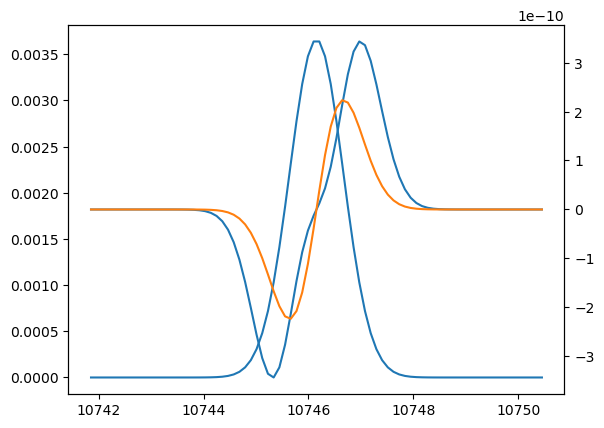

In [78]:
plt.figure()
plt.plot(wvvec,stokes[iray,:,0])
plt.twinx()
plt.plot(wvvec,stokes[iray,:,3])
blos_fit = np.sum(stokes[iray,:,3]/Vf_over_blos * stokes[iray,:,0]) / np.sum(stokes[iray,:,0]) 
print(blos_fit)
plt.plot(wvvec,Vf_over_blos * blos_fit)

In [79]:
blos_inf = np.zeros(nrays)

for iray in trange(nrays): 
    Vf_over_blos = - 4.6686e-10 * (wvvec.mean()**2) /1000. * fe13_ln1.geff *  np.gradient(stokes[iray,:,0],wvvec)  
    blos_inf[iray] = np.sum(stokes[iray,:,3]/Vf_over_blos * stokes[iray,:,0]) / np.sum(stokes[iray,:,0]) 

  0%|          | 0/81225 [00:00<?, ?it/s]

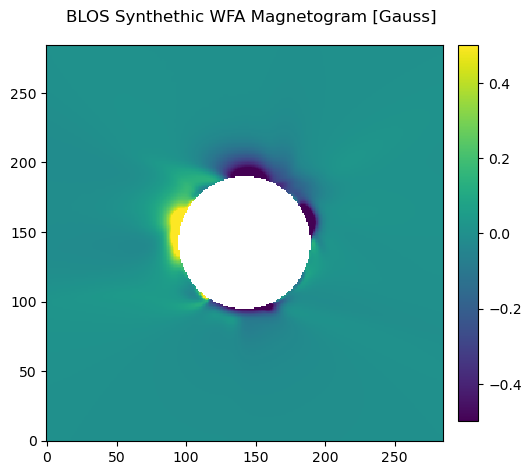

In [80]:
fig = plt.figure()
plt.imshow(blos_inf.reshape(*yya.shape))
plt.clim(-0.5,0.5)
cbars = []
axi = plt.gca()
cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
cbars.append(cbar1)
fig.suptitle('BLOS Synthethic WFA Magnetogram [Gauss]')
fig.tight_layout()